In [1]:
import pandas as pd
import copy
import numpy as np
from datetime import datetime
import os
import re
import glob
from omegaconf import OmegaConf
from typing import List
from multiprocessing import Pool
from matplotlib.gridspec import GridSpec
import uncertainty_toolbox as uct
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from hydra.utils import instantiate
from scipy.stats import norm

from tropical_cyclone_dm import TropicalCycloneSequenceDataModule

plt.rcParams["figure.figsize"] = [14, 5]

color_palette = {
    # "MVEClassification": "#1f77b4",  # Blue
    # "QuantileClassification": "#ff7f0e",  # Orange
    "DKLClassification": "#2ca02c",  # Green
    "LaplaceClassification": "#d62728",  # Red
    "DeepEnsembleClassification": "#9467bd",  # Purple
    "MCDropoutClassification": "#8c564b",  # Brown
    "SWAGClassification": "#e377c2",  # Pink
    "BNN_VI_ELBO_Classification": "#7f7f7f",  # Gray
    "DER": "#bcbd22",  # Lime
    "DUEClassification": "#17becf",  # Teal
    "DeterministicClassification": "#aec7e8",  # Light Blue
    "ConformalQR": "#ffbb78",  # Light Orange
    "CARDClassification": "#98df8a",
}

VAR_TO_PLOT_LABEL = {
    "mae": "MAE",
    "rmse": "RMSE",
    "pred_uct": "Pred. Uncertainty",
    "coverage": "Coverage",
    "sharpness": "Sharpness",
    "calibration": "Calibration",
    "correlation": "Correlation",
    "nll": "NLL",
    "mace": "MACE",
    "crps": "CRPS",
    "proportion_in_0.9_interval": "Proportion in 0.9 Interval",
    "TD": "Tropical Depression",
    "TS": "Tropical Storm",
    "H1": "Cat 1 Hurricane",
    "H2": "Cat 2 Hurricane",
    "H3": "Cat 3 Hurricane",
    "H4": "Cat 4 Hurricane",
    "H5": "Cat 5 Hurricane",
    "DKLClassification": "DKL",
    "LaplaceClassification": "Laplace",
    "DeepEnsembleClassification": "Deep Ensemble",
    "MCDropoutClassification": "MC Dropout",
    "SWAGClassification": "SWAG",
    "BNN_VI_ELBO_Classification": "BNN VI ELBO",
    "DUEClassification": "DUE",
    "DeterministicClassification": "Deterministic",
    "CARDClassification": "CARD",
}

%load_ext autoreload
%autoreload 2

In [2]:
# specify directories to include in analysis
directories = [
    "/p/project/hai_uqmethodbox/experiment_output/test_class",

]
paths = [
    file
    for directory in directories
    for file in glob.glob(os.path.join(directory, "*", "pred*.csv"))
    if os.path.exists(os.path.join(os.path.dirname(file), "config.yaml"))
]


# selective prediction threshold
SELECTIVE_THRESH = 12

# https://www.nhc.noaa.gov/aboutsshws.php
# wind speed is in knots in this competition
CLASS_BINS = {
    "TD": (0, 33),
    "TS": (34, 63),
    "H1": (64, 82),
    "H2": (83, 95),
    "H3": (96, 112),
    "H4": (113, 136),
    "H5": (137, np.inf),
}
BIN_EDGES = [0] + [v[1] for v in CLASS_BINS.values()]
CLASS_LABELS = list(CLASS_BINS.keys())


# choosee one type of selective prediction procedure from ["absolute", "method", "category_conditional"]
SELECTIVE_PROCEDURE = "absolute"

# TODO map them to readable names
STORM_DISPLAY_ORDER = ["all", "TD", "TS", "H1", "H2", "H3", "H4", "H5"]

DS_SPLIT = "test"


UQ_METHOD_DISPLAY_ORDER = [
    "DeterministicClassification",
    "DeepEnsembleClassification",
    "MCDropoutClassification",
    "SWAGClassification",
    "LaplaceClassification",
    "BNN_VI_ELBO_Classification",
    "DKLClassification",
    "DUEClassification",
    "CARDClassification",
]

# Define the groups
UQ_METHOD_GROUPS = {
    "Bayesian": [
        "MCDropoutClassification",
        "SWAGClassification",
        "LaplaceClassification",
        "BNN_VI_ELBO_Classification",
        "DKLClassification",
        "DUEClassification",
    ],
    "Ensemble": ["DeepEnsembleClassification"],
    "Diffusion": ["CARDClassification"],
}

In [3]:
paths

['/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_02-14-2024_14-02-22-295163/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_02-14-2024_14-02-22-295163/preds_test.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_02-14-2024_14-02-22-295163/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_BNN_VI_ELBO_Classification_02-14-2024_14-02-22-295137/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_BNN_VI_ELBO_Classification_02-14-2024_14-02-22-295137/preds_test.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_BNN_VI_ELBO_Classification_02-14-2024_14-02-22-295137/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_BNN

In [4]:
def compute_overview_df(paths):
    pattern = r"(\d{2}-\d{2}-\d{4})"
    datetime_format = "%d-%m-%Y_%H-%M-%S-%f"
    overview_df = pd.DataFrame()
    for idx, path in enumerate(paths):
        exp_dict = {}
        try:
            conf = OmegaConf.load(os.path.join(os.path.dirname(path), "config.yaml"))
        except FileNotFoundError:
            print(f"Config not found for {path}")
            continue
        if "post_processing" in conf:
            exp_dict["uqmethod"] = conf.post_processing["_target_"].split(".")[-1]
        else:
            exp_dict["uqmethod"] = conf.uq_method["_target_"].split(".")[-1]

        match = re.search(pattern, path)
        date_str = match.group(1)

        # Convert string to datetime object
        date = datetime.strptime(date_str, "%m-%d-%Y")
        # exp_dict["date"] = datetime.strptime(date_string, datetime_format)
        exp_dict["pred_path"] = path
        exp_dict["conf_path"] = re.sub(r'preds_.*\.csv', 'config.yaml', path)
        exp_dict["metric_path"] = os.path.join(
            os.path.dirname(path), "csv_logs", "version_0", "metrics.csv"
        )
        overview_df = pd.concat([overview_df, pd.DataFrame(exp_dict, index=[idx])])

    return overview_df


overview_df = compute_overview_df(paths)
overview_df

,uqmethod,pred_path,conf_path,metric_path
0,DKLClassification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
1,DKLClassification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
2,DKLClassification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
3,BNN_VI_ELBO_Classification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
4,BNN_VI_ELBO_Classification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
5,BNN_VI_ELBO_Classification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
6,BNN_VI_ELBO_Classification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
7,BNN_VI_ELBO_Classification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
8,BNN_VI_ELBO_Classification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
9,MCDropoutClassification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...


In [5]:
with pd.option_context("display.max_colwidth", None):
    display(overview_df.conf_path)

0               /p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_02-14-2024_14-02-22-295163/config.yaml
1               /p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_02-14-2024_14-02-22-295163/config.yaml
2               /p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_02-14-2024_14-02-22-295163/config.yaml
3      /p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_BNN_VI_ELBO_Classification_02-14-2024_14-02-22-295137/config.yaml
4      /p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_BNN_VI_ELBO_Classification_02-14-2024_14-02-22-295137/config.yaml
5      /p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_BNN_VI_ELBO_Classification_02-14-2024_14-02-22-295137/config.yaml
6      /p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/config.yaml
7      /p/project/hai_uqmethodbox/experim

In [6]:
datamodule = instantiate(OmegaConf.load(overview_df.conf_path.iloc[0]).datamodule)
datamodule.setup("fit")
datamodule.setup(stage="test")

In [7]:
dataset = datamodule.dataset
train_ds = datamodule.train_dataset
val_ds = datamodule.val_dataset
test_ds = datamodule.test_dataset
calib_ds = datamodule.calibration_dataset

print(len(dataset)), print(len(train_ds)), print(len(val_ds)), print(
    len(calib_ds)
), print(len(test_ds))
ds = datamodule.test_dataset
WIND_SPEED_BINS = ds.wind_speed_bins

DS_DICT = {"train": dataset, "val": dataset, "test": test_ds}
print(WIND_SPEED_BINS)

69267
56348
10335
2584
43635
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185]


In [8]:
bin_intervals = np.diff(WIND_SPEED_BINS)
bin_intervals =(np.append(bin_intervals, bin_intervals[-1]) / 2) + WIND_SPEED_BINS
bin_intervals, len(bin_intervals)

(array([  2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
         47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,
         92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5,
        137.5, 142.5, 147.5, 152.5, 157.5, 162.5, 167.5, 172.5, 177.5,
        182.5, 187.5]),
 38)

In [15]:
import pandas as pd

from scipy.stats import norm
from scipy.optimize import curve_fit
from tqdm import trange, tqdm
from joblib import Parallel, delayed

# Define a function to fit a Gaussian
def fit_gaussian(x, mean, std_dev):
    return norm.pdf(x, mean, std_dev)

def fit_gaussian_to_row(row, bin_midpoints):
    p0 = [np.mean(row), np.std(row)]
    popt, _ = curve_fit(fit_gaussian, bin_midpoints, row, p0=p0, maxfev=2000)
    return popt

def process_overview_df(overview_df):
    overview_df["split"] = overview_df["pred_path"].str.split(os.sep, expand=True)[7]

    all_test_pred_df = []
    for idx, row in overview_df.iterrows():
        pred_df = pd.read_csv(row["pred_path"])
        pred_df["uqmethod"] = row["uqmethod"]
        if row["split"] == "preds.csv":
            pred_df["split"] = "preds_test"
        else:
            pred_df["split"] = row["split"].split(".")[0]

        pred_df["pred_path"] = row["pred_path"]
        all_test_pred_df.append(pred_df)

    all_test_pred_df = pd.concat(all_test_pred_df, ignore_index=True)

    # all_test_pred_df = all_test_pred_df[(all_test_pred_df["uqmethod"] == "DKLClassification") & (all_test_pred_df["split"] == "preds_test")]

    # date
    pattern = r"(\d{2}-\d{2}-\d{4}_\d{2}-\d{2}-\d{6})"

    # Extract dates and create a new column
    all_test_pred_df["date"] = all_test_pred_df["pred_path"].str.extract(pattern)

    # Convert the new_date_column to datetime format
    all_test_pred_df["date"] = pd.to_datetime(
        all_test_pred_df["date"], format="%m-%d-%Y_%H-%M"
    )
    def compute_bin_mean_prediction(row, bin_edges):
        x = row["pred"]
        if x < len(bin_edges) - 1:
            return (bin_edges[x] + bin_edges[x+1]) / 2
        else:
            # extend the last category bin
            return (bin_edges[x] + dataset.class_bin_size) / 2

    # argmax Classification prediction
    all_test_pred_df['argmax_reg'] = all_test_pred_df.apply(lambda row: compute_bin_mean_prediction(row, WIND_SPEED_BINS), axis=1)

    # weighted softamx Classification prediction
    logit_cols = [col for col in all_test_pred_df.columns if col.startswith('logit_')]

    # Compute softmax values for each logit
    exp_logits = np.exp(all_test_pred_df[logit_cols].values)
    softmax_values = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # Compute bin intervals
    bin_intervals = np.diff(WIND_SPEED_BINS) / 2
    bin_midpoints = (np.append(bin_intervals, bin_intervals[-1])) + WIND_SPEED_BINS

    # Compute weighted average of the softmax over the logits
    all_test_pred_df['softmax_weighted_reg'] = np.sum(softmax_values * bin_midpoints, axis=1)

    logits = all_test_pred_df[logit_cols].values

    # Fit a Gaussian to the softmax logits
    gaussian_params = Parallel(n_jobs=12)(delayed(fit_gaussian_to_row)(row, np.arange(len(logit_cols))) for row in tqdm(logits, desc="Fitting Gaussians"))
    # Convert the list of tuples into a DataFrame
    gaussian_params_df = pd.DataFrame(gaussian_params, columns=['gaussian_mean', 'gaussian_std'])

    # Assign the columns of the DataFrame to new columns in all_test_pred_df
    all_test_pred_df[['gaussian_mean', 'gaussian_std']] = gaussian_params_df

    all_test_pred_df = all_test_pred_df.reset_index(drop=True)
    
    return all_test_pred_df

all_test_pred_df = process_overview_df(overview_df)
all_test_pred_df

Fitting Gaussians:   0%|          | 72/772226 [00:06<15:11:36, 14.12it/s]/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
Fitting Gaussians:   0%|          | 231/772226 [00:06<3:22:36, 63.50it/s]/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/sc

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.

Fitting Gaussians:  33%|███▎      | 255000/772226 [02:00<02:30, 3443.08it/s]

5 4.961873813073532


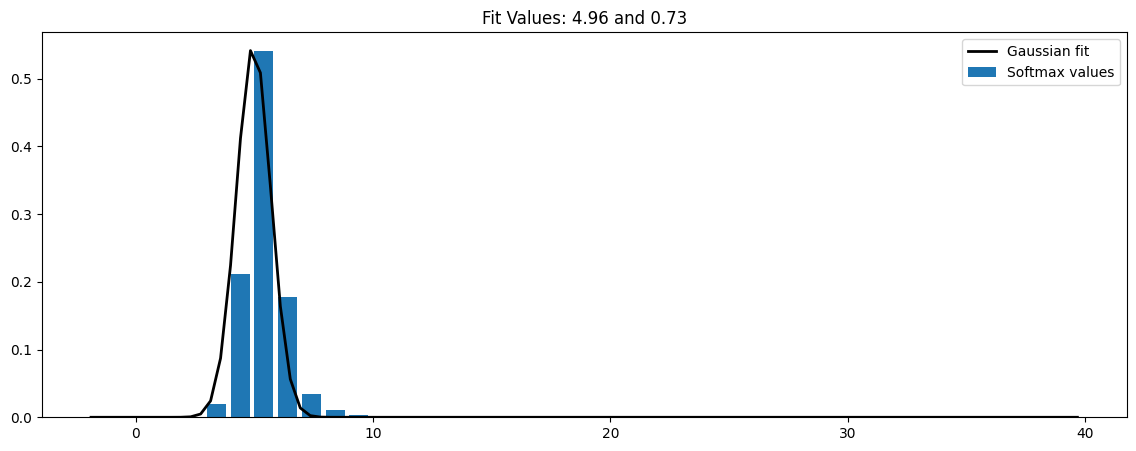

In [ ]:
logit_cols = [col for col in all_test_pred_df.columns if col.startswith('logit_')]

# Compute softmax values for each logit
# exp_logits = np.exp(all_test_pred_df[logit_cols].values)
# softmax_values = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
softmax_values = all_test_pred_df[logit_cols].values
 
bin_intervals = np.diff(WIND_SPEED_BINS) / 2
bin_midpoints = (np.append(bin_intervals, bin_intervals[-1])) + WIND_SPEED_BINS

# Select the first row of softmax values
softmax_row = softmax_values[20, :]

from scipy.optimize import curve_fit

# Define a Gaussian function
def gaussian(x, mu, std):
    return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / std)**2)

# Fit a Gaussian to the softmax values
popt, pcov = curve_fit(gaussian, np.arange(len(softmax_row)), softmax_row, p0=[0, 1])

# Extract the fitted parameters
mu, std = popt

# Plot the softmax values as a bar plot
plt.bar(np.arange(len(softmax_row)), softmax_row, align='edge', label='Logit values')

# Plot the Gaussian fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = gaussian(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Gaussian fit')

# Add a title and legend
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
plt.legend()

print(np.argmax(softmax_row), mu)
# Display the plot
plt.show()

,pred,pred_uct,target,storm_id,index,wind_speed,logit_0,logit_1,logit_2,logit_3,...,logit_36,logit_37,uqmethod,split,pred_path,relative_time,ocean,date,argmax_reg,softmax_weighted_reg
0,5,1.420503,5,nkd,34356,25,0.000012,0.000012,0.000012,0.003466,...,0.000013,0.000012,DKLClassification,preds_val,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_02-14-2024_14-02-22-295163/preds_val.csv,NaN,NaN,NaT,27.5,93.098362
1,6,1.527950,7,aya,2398,35,0.000010,0.000009,0.000010,0.002089,...,0.000010,0.000010,DKLClassification,preds_val,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_02-14-2024_14-02-22-295163/preds_val.csv,NaN,NaN,NaT,32.5,93.180510
2,6,1.455595,5,cjx,5222,25,0.000010,0.000010,0.000011,0.002767,...,0.000011,0.000011,DKLClassification,preds_val,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_02-14-2024_14-02-22-295163/preds_val.csv,NaN,NaN,NaT,32.5,93.128150
3,9,2.128391,7,ohj,35834,35,0.000005,0.000004,0.000005,0.000024,...,0.000005,0.000005,DKLClassification,preds_val,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_02-14-2024_14-02-22-295163/preds_val.csv,NaN,NaN,NaT,47.5,93.856002
4,7,1.871983,6,kyq,30675,31,0.000004,0.000003,0.000003,0.000189,...,0.000004,0.000004,DKLClassification,preds_val,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_02-14-2024_14-02-22-295163/preds_val.csv,NaN,NaN,NaT,37.5,93.501074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10330,11,2.214740,14,iaz,24960,70,0.000008,0.000007,0.000007,0.000011,...,0.000008,0.000008,DKLClassification,preds_val,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_02-14-2024_14-02-22-295163/preds_val.csv,NaN,NaN,NaT,57.5,94.047791
10331,20,2.416331,21,fzw,17784,108,0.000266,0.000254,0.000270,0.000006,...,0.000273,0.000274,DKLClassification,preds_val,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_02-14-2024_14-02-22-295163/preds_val.csv,NaN,NaN,NaT,102.5,95.293398
10332,6,1.739737,9,vib,54325,45,0.000005,0.000005,0.000005,0.000570,...,0.000006,0.000005,DKLClassification,preds_val,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_02-14-2024_14-02-22-295163/preds_val.csv,NaN,NaN,NaT,32.5,93.359832
10333,7,1.870373,6,xmf,61496,33,0.000003,0.000003,0.000003,0.000178,...,0.000003,0.000003,DKLClassification,preds_val,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_02-14-2024_14-02-22-295163/preds_val.csv,NaN,NaN,NaT,37.5,93.502698


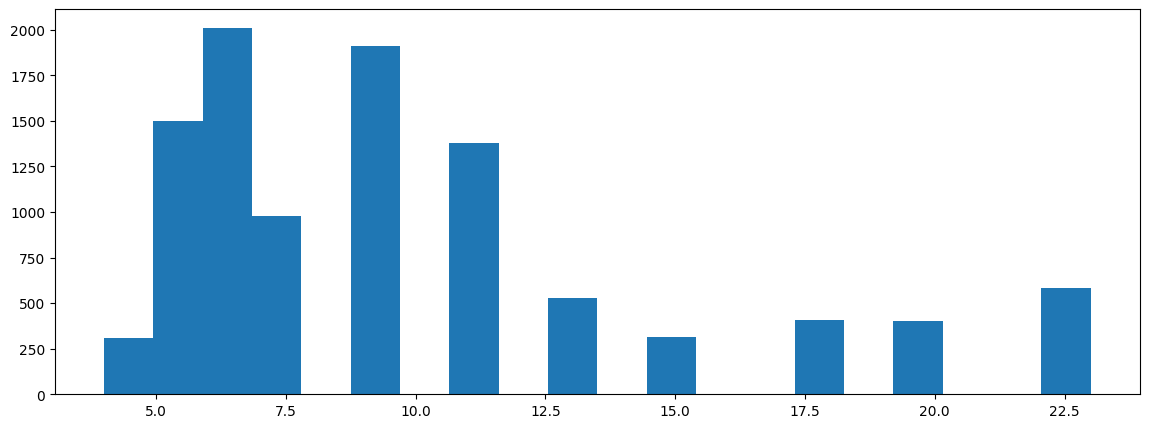

In [11]:
with pd.option_context("display.max_colwidth", None):
    df = all_test_pred_df[(all_test_pred_df["uqmethod"] == "DKLClassification") & (all_test_pred_df["split"] == "preds_val")]
    display(
        df
    )
    fig, ax = plt.subplots(1)
    ax.hist(df["pred"], bins=20, label="target")
    plt.show()

In [14]:
def compute_metrics(df, pred_col: str):    
    df["mse"] = (df[pred_col] - df["wind_speed"]) ** 2
    df["mae"] = np.abs(df[pred_col] - df["wind_speed"])
    metric_df = df.groupby(["uqmethod", "split", "pred_path"]).agg({"mse": "mean", "mae": "mean"}).reset_index()
    metric_df['rmse'] = metric_df['mse'].apply(np.sqrt)
    return metric_df 
# choose over which pred type column to compute the metrics
with pd.option_context("display.max_colwidth", None):
    display(
        compute_metrics(all_test_pred_df, "argmax_reg")
    )

,uqmethod,split,pred_path,mse,mae,rmse
0,BNN_VI_ELBO_Classification,preds_test,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_BNN_VI_ELBO_Classification_02-14-2024_14-02-22-295137/preds_test.csv,209.475759,9.760594,14.473277
1,BNN_VI_ELBO_Classification,preds_test,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/preds_test.csv,116.802905,7.994443,10.807539
2,BNN_VI_ELBO_Classification,preds_train,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_BNN_VI_ELBO_Classification_02-14-2024_14-02-22-295137/preds_train.csv,184.348956,8.843934,13.577517
3,BNN_VI_ELBO_Classification,preds_train,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/preds_train.csv,89.653315,6.947984,9.468543
4,BNN_VI_ELBO_Classification,preds_val,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_BNN_VI_ELBO_Classification_02-14-2024_14-02-22-295137/preds_val.csv,342.655806,11.704257,18.510964
5,BNN_VI_ELBO_Classification,preds_val,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/preds_val.csv,122.058805,8.150314,11.048023
6,DKLClassification,preds_test,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_02-14-2024_14-02-22-295163/preds_test.csv,99.402424,7.449696,9.970076
7,DKLClassification,preds_train,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_02-14-2024_14-02-22-295163/preds_train.csv,84.303525,6.926475,9.181695
8,DKLClassification,preds_val,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_02-14-2024_14-02-22-295163/preds_val.csv,116.650968,7.921867,10.800508
9,DeterministicClassification,preds_test,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DeterministicClassification_02-14-2024_14-02-22-295135/preds_test.csv,167.806228,9.715492,12.954004


        pred  pred_uct  target storm_id  index  wind_speed   logit_0  logit_1  \
680016    14  3.616983      13      erp   7773          65  0.000069  0.00007   

         logit_2   logit_3  ...                 uqmethod       split  \
680016  0.000069  0.000068  ...  MCDropoutClassification  preds_test   

                                                pred_path  relative_time  \
680016  /p/project/hai_uqmethodbox/experiment_output/t...       392385.0   

        ocean  date  argmax_reg  softmax_weighted_reg    mse  mae  
680016    1.0   NaT        72.5              94.07953  56.25  7.5  

[1 rows x 54 columns]
7773


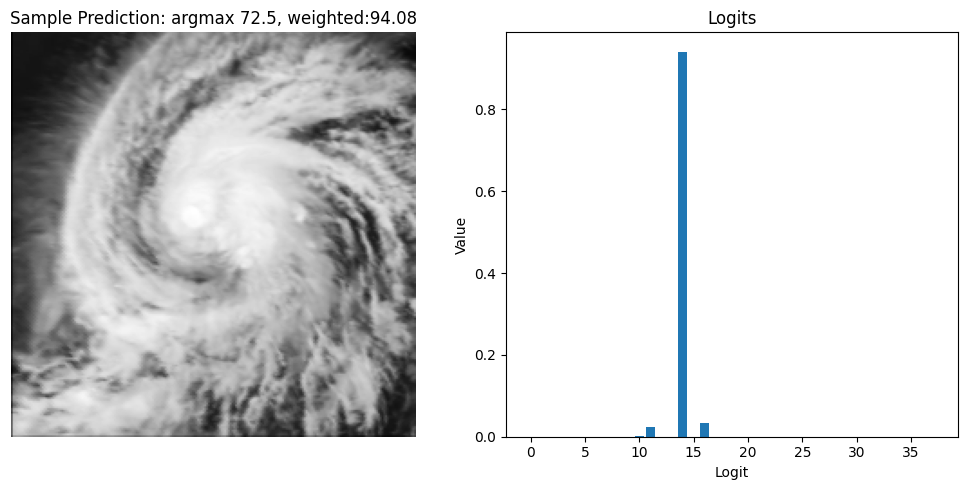

In [13]:
import matplotlib.pyplot as plt

def plot_method(all_test_pred_df, method: str, data_split: str):
    # Select rows for the given method
    df_method = all_test_pred_df[all_test_pred_df['uqmethod'] == method]
    df_method = df_method[df_method["split"] == f"preds_{data_split}"]

    # If there's no data for the given method, return
    if df_method.empty:
        print(f"No data for method: {method}")
        return

    # Select a random row (sample) from the dataframe
    sample = df_method.sample(1)

    # Extract logit columns (columns that start with 'logt_')
    logit_cols = [col for col in df_method.columns if col.startswith('logit_')]
    logits = sample[logit_cols].values[0]

    # Create a figure with two subplots: one for the prediction, one for the logits
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    print(sample)
    print(sample["index"].iloc[0])
    img = DS_DICT[data_split][int(sample["index"].iloc[0])]["input"]
    # Plot prediction
    axs[0].imshow(img[0,...], cmap="gray")
    axs[0].set_title(f'Sample Prediction: argmax {sample["argmax_reg"].iloc[0]}, weighted:{sample["softmax_weighted_reg"].iloc[0]:.2f}')
    axs[0].set_xlabel('Index')
    axs[0].axis("off")
    axs[0].set_ylabel('Prediction')

    # Plot logits
    axs[1].bar(range(len(logit_cols)), logits)
    axs[1].set_title('Logits')
    axs[1].set_xlabel('Logit')
    axs[1].set_ylabel('Value')

    # Display the plot
    plt.tight_layout()
    plt.show()

plot_method(all_test_pred_df, "MCDropoutClassification", DS_SPLIT)